## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import tensorflow as tf
from keras.utils import to_categorical # convert to one-hot-encoding

import warnings
warnings.filterwarnings('ignore')

import cv2

from utils import *

## Data

In [2]:
# Set the base directory to location #change

project_path = 'C:\\Users\\Martin\\OneDrive - NOVAIMS\\Documents\\Universidade\\3º Ano\\Deep Learning\\Project'
# project_path = 'C:\\Users\\Afonso Cadete\\Documents\\Projects Data\\Deep Learning'
# project_path = 'C:\\Users\\Afonso Cadete\\Documents\\Projects Data\\Deep Learning'
# project_path = 'C:\\Users\\Afonso Cadete\\Documents\\Projects Data\\Deep Learning'

# Merge images from both folders train and test into one dictionary
images_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(project_path, '*', '*.jpg'))}

# Read the metadata CSV file from directory
metadata = pd.read_csv(os.path.join(project_path, 'HAM10000_metadata.csv'))

# Create new columns for better readability #change
metadata['path'] = metadata['image_id'].map(images_path_dict.get)

# Convert image paths to NumPy arrays with RGB channels
metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image.open(x))) # faster than cv2.imread

# Create train and test dataframes
train_data = metadata[metadata['path'].str.contains('train')]
test_data = metadata[metadata['path'].str.contains('test')]

# Delete unnecessary columns
train_data.drop(columns=['lesion_id', 'image_id', 'path'], inplace=True)
test_data.drop(columns=['lesion_id', 'image_id', 'path'], inplace=True)

# EDA

### Train percentage of Data

In [3]:
100 * len(train_data)/len(metadata)

74.99750374438342

### Missing Values

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7511 entries, 0 to 10014
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dx            7511 non-null   object 
 1   dx_type       7511 non-null   object 
 2   age           7467 non-null   float64
 3   sex           7511 non-null   object 
 4   localization  7511 non-null   object 
 5   image         7511 non-null   object 
dtypes: float64(1), object(5)
memory usage: 410.8+ KB


In [5]:
missing_values_percentage(train_data, 'age')

Percentage of "age" missing values: 0.59%


### Variable Distributions

#### Numerical features

In [6]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,7467.0,51.7122,16.944405,0.0,40.0,50.0,65.0,85.0


#### `age`

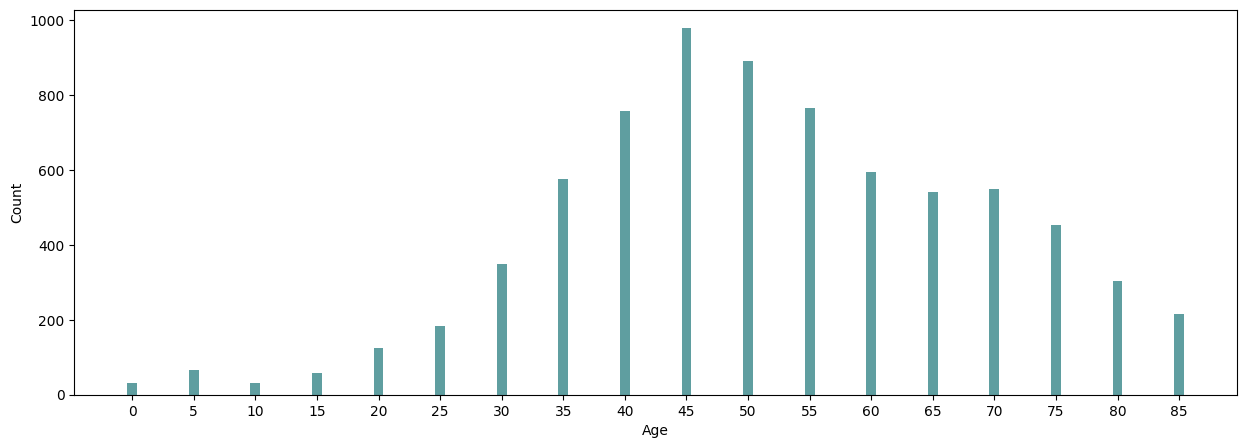

In [7]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'age', 'Age')

#### Categorical features

In [9]:
train_data.iloc[:,:-1].describe(exclude=['number']).T

,count,unique,top,freq
dx,7511,7,nv,5029
dx_type,7511,4,histo,4014
sex,7511,3,male,4052
localization,7511,15,back,1634


#### `dx` --- Target

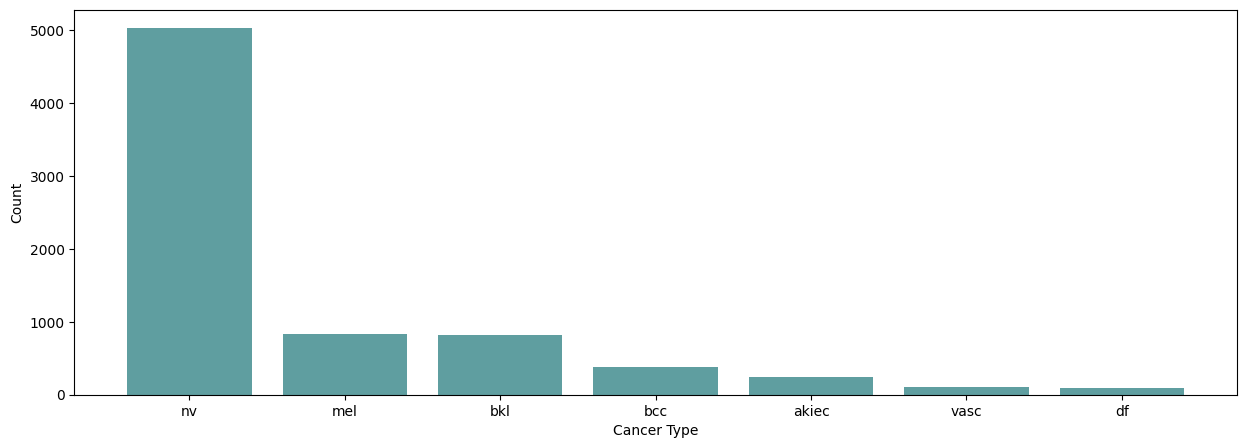

In [10]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'dx', 'Cancer Type')

#### `dx_type`

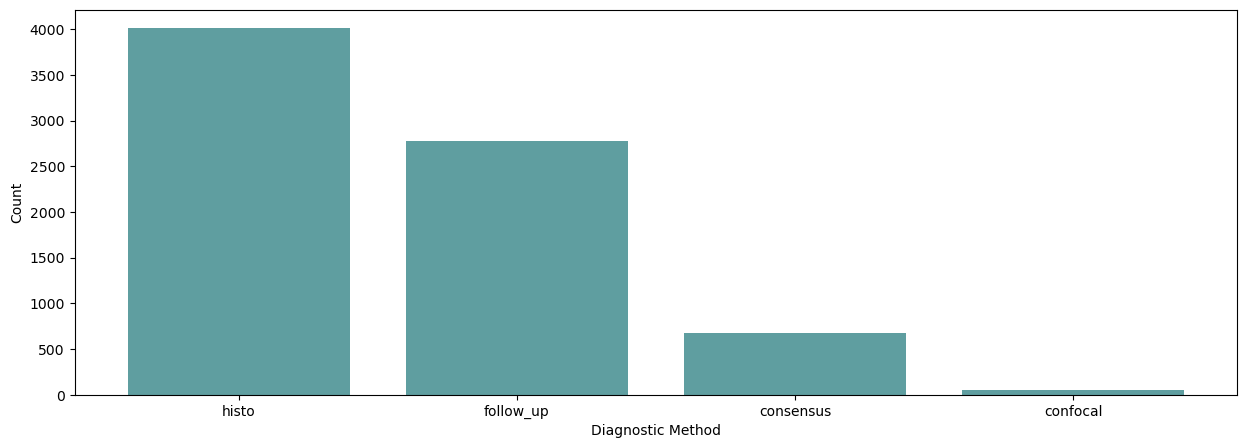

In [11]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'dx_type', 'Diagnostic Method')

#### `sex`

- (choose either bar chart or pie chart)

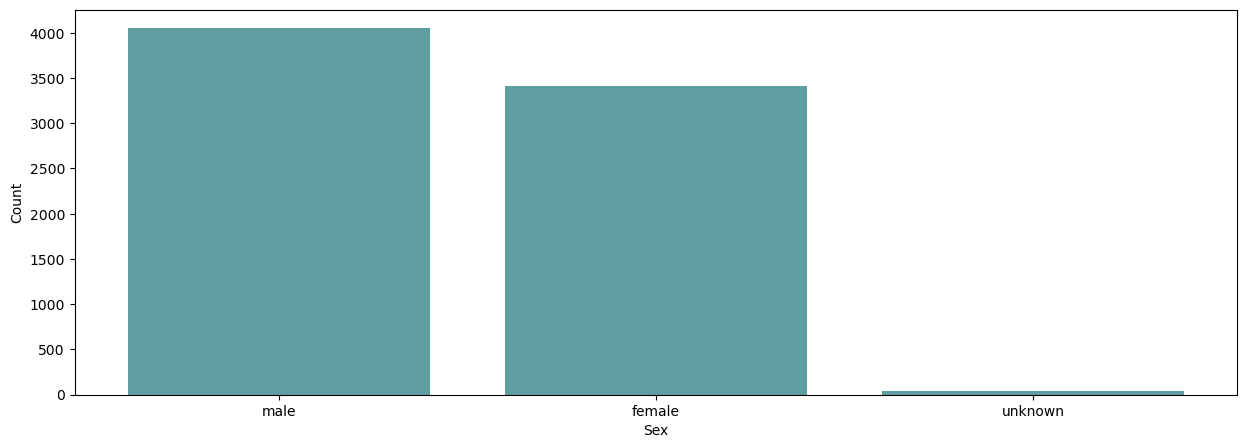

In [12]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'sex', 'Sex')

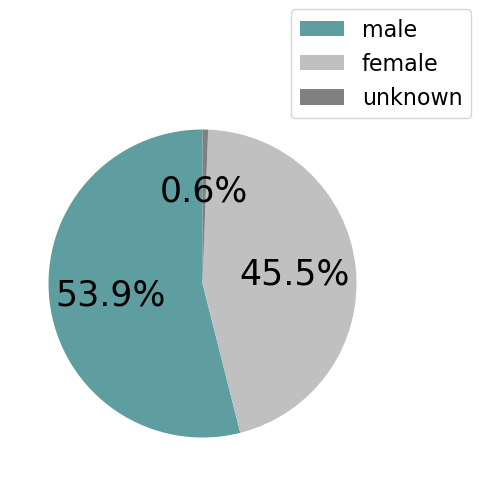

In [13]:
plot_pie_chart(train_data, 'sex', colors=['cadetblue', 'silver', 'grey'], legend=['male', 'female', 'unknown'])

#### `localization`

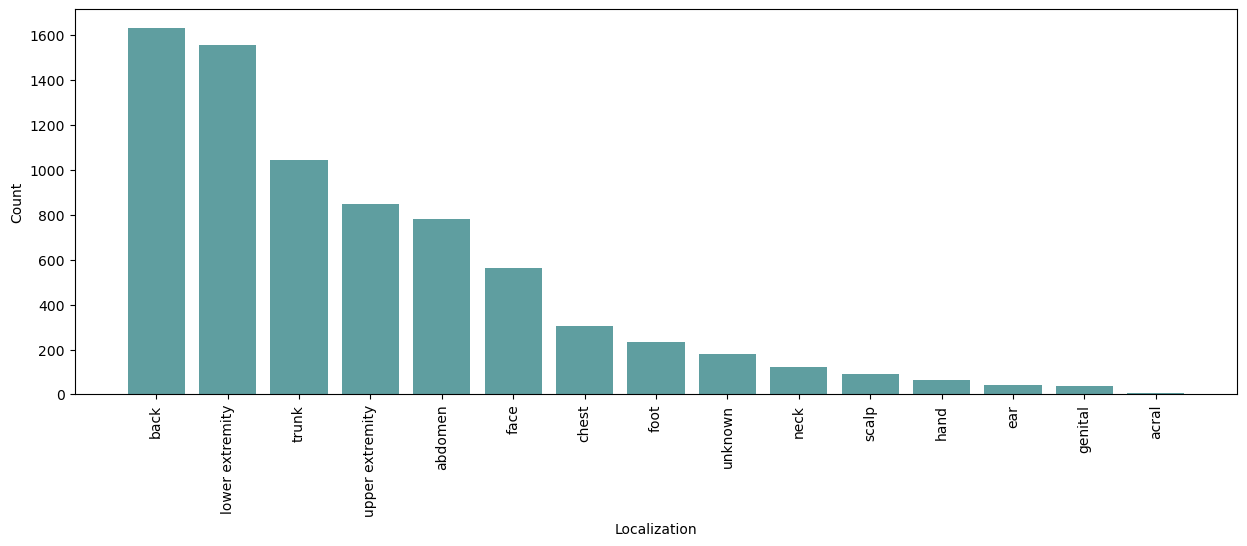

In [14]:
fig, ax = plt.subplots()
plt.xticks(rotation=90)
plot_bar_chart(ax, train_data, 'localization', 'Localization')

### Variable's `image` Structure

In [15]:
train_data['image'].map(lambda x: x.shape).value_counts() # height, width, channels

(450, 600, 3)    7511
Name: image, dtype: int64

## Data Preparation (feature extraction?)

Creating a copy of the dataset for the sake of safety

In [12]:
# train = train_data.sample(frac=0.5, random_state=21)
train = train_data.copy()

Creating a list with all values of each image

In [14]:
X_train = np.asarray(train['image'].tolist())
X_train

array([[[[188, 147, 191],
         [186, 148, 189],
         [187, 150, 191],
         ...,
         [196, 155, 171],
         [197, 156, 170],
         [197, 157, 168]],

        [[186, 149, 193],
         [187, 152, 194],
         [189, 153, 191],
         ...,
         [194, 156, 169],
         [195, 159, 169],
         [192, 159, 168]],

        [[185, 148, 192],
         [189, 152, 195],
         [190, 153, 196],
         ...,
         [196, 155, 169],
         [198, 157, 171],
         [194, 156, 169]],

        ...,

        [[157, 124, 155],
         [156, 121, 154],
         [159, 124, 154],
         ...,
         [177, 146, 161],
         [176, 144, 159],
         [175, 141, 155]],

        [[155, 122, 151],
         [156, 123, 154],
         [156, 123, 152],
         ...,
         [178, 147, 163],
         [175, 144, 159],
         [175, 142, 159]],

        [[154, 119, 151],
         [153, 120, 149],
         [154, 121, 152],
         ...,
         [176, 147, 167],
        

Convert the `target` to a categorical feature and one-hot encode it (not sure if its true, proof read pls) 

In [15]:
y_train = pd.Categorical(train['dx']).codes

y_train = to_categorical(y_train, num_classes = 7)

Scaling `image` values

In [17]:
scaled_X_train = X_train.astype('float32') / 255

MemoryError: Unable to allocate 22.7 GiB for an array with shape (7511, 450, 600, 3) and data type float32

In [ ]:
scaled_X_train

array([[[[0.05882353, 0.01960784, 0.01568628],
         [0.0627451 , 0.02745098, 0.03921569],
         [0.0627451 , 0.02745098, 0.03921569],
         ...,
         [0.00784314, 0.        , 0.01176471],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.        ]],

        [[0.05490196, 0.03529412, 0.02352941],
         [0.05098039, 0.03137255, 0.04705882],
         [0.05490196, 0.03921569, 0.02745098],
         ...,
         [0.01176471, 0.00392157, 0.01568628],
         [0.01176471, 0.00392157, 0.01568628],
         [0.        , 0.        , 0.        ]],

        [[0.05098039, 0.03137255, 0.04705882],
         [0.05490196, 0.03137255, 0.04705882],
         [0.06666667, 0.03137255, 0.04313726],
         ...,
         [0.01176471, 0.00392157, 0.01568628],
         [0.01568628, 0.00784314, 0.02745098],
         [0.01176471, 0.00392157, 0.01568628]],

        ...,

        [[0.20784314, 0.1254902 , 0.14509805],
         [0.20784314, 0.13725491, 0.13725491]

In [46]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [47]:
from skimage.color import rgb2gray
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator
from skimage import img_as_float32

# def preprocess_images(images, target_size=(90, 120), color_mode='grayscale'):
#     processed_images = []
#     for img in images:
#         # Resize image if not already in target size
#         if img.shape[:2] != target_size:
#             img = resize(img, target_size, anti_aliasing=True)
#         # Convert to grayscale if not already
#         if color_mode == 'grayscale' and img.ndim == 3 and img.shape[2] == 3:
#             img = rgb2gray(img)
#             img = np.expand_dims(img, axis=-1)  # Add back the channel dimension
#         processed_images.append(img_as_float32(img))  # Ensure type is float32 for Keras
#     return np.array(processed_images)

In [48]:
processed_images = []

for image in X_train:
    image = resize(image, (90,120,3), anti_aliasing=False)
    processed_images.append(img_as_float32(image))

rescaled_X_train = np.array(processed_images)

In [49]:
rescaled_X_train

array([[[[0.06666667, 0.03137255, 0.04313726],
         [0.08235294, 0.03137255, 0.05882353],
         [0.09411765, 0.05098039, 0.07450981],
         ...,
         [0.01960784, 0.01568628, 0.        ],
         [0.01568628, 0.00784314, 0.01176471],
         [0.01176471, 0.00392157, 0.01568628]],

        [[0.05882353, 0.04313726, 0.03921569],
         [0.09411765, 0.05098039, 0.06666667],
         [0.1254902 , 0.10196079, 0.10196079],
         ...,
         [0.03529412, 0.01960784, 0.01568628],
         [0.01960784, 0.01568628, 0.00784314],
         [0.01568628, 0.00784314, 0.01176471]],

        [[0.09803922, 0.04705882, 0.08235294],
         [0.13725491, 0.07843138, 0.09803922],
         [0.23921569, 0.11764706, 0.14117648],
         ...,
         [0.04705882, 0.03137255, 0.02745098],
         [0.03137255, 0.01568628, 0.01960784],
         [0.02352941, 0.01568628, 0.01960784]],

        ...,

        [[0.3137255 , 0.20392157, 0.2509804 ],
         [0.38039216, 0.25490198, 0.29803923]

In [50]:
# ct = ColumnTransformer([('oneHot', OneHotEncoder(), [0,1,3,4])], remainder='passthrough')
# train = ct.fit_transform(train.iloc[:,:-1])

In [51]:
# partial_X_train, X_val, partial_y_train, y_val = train_test_split(X_train,
#                                                                   y_train,
#                                                                   test_size=0.25,
#                                                                   random_state=21,
#                                                                   stratify=y_train,
#                                                                   shuffle=True
#                                                                   )

In [52]:
# X_val

In [53]:
# st_scaler = StandardScaler()
# st_scaler.fit(partial_X_train)
# partial_X_train_st = st_scaler.transform(partial_X_train)
# X_val_st = st_scaler.transform(X_val)

In [54]:
# # Preprocess the images
# rescaled_partial_X_train = preprocess_images(partial_X_train)
# rescaled_X_val = preprocess_images(X_val)

In [55]:
# rescaled_partial_X_train

In [56]:
# scaled_partial_X_train = rescaled_partial_X_train.astype('float32') / 255
# scaled_X_val = rescaled_X_val.astype('float32') / 255

In [63]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(40, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(90, 120, 3)))
model.add(MaxPooling2D((3,3)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
import gc
from keras.callbacks import Callback

# class MemoryCleanup(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print("Memory cleanup called at the end of epoch:", epoch)
#         gc.collect()

# clear_memory = MemoryCleanup()

# # Create a data generator for the training data
# train_datagen = ImageDataGenerator()
# train_generator = train_datagen.flow(
#     x=rescaled_partial_X_train,
#     y=rescaled_partial_y_train,
#     batch_size=64  # Further reduced batch size
# )

# Fit the model using the generator
history = model.fit(rescaled_X_train,
                    y_train,
                    batch_size=64,
                    epochs=10,
                    # verbose=1,
                    validation_split=0.25,
                    # callbacks=[clear_memory]
                   )


Epoch 1/10
45/45 [==============================] - 26s 517ms/step - loss: 6.7663 - accuracy: 0.4995 - val_loss: 1.1158 - val_accuracy: 0.6581
Epoch 2/10
45/45 [==============================] - 22s 469ms/step - loss: 1.1766 - accuracy: 0.6312 - val_loss: 1.0836 - val_accuracy: 0.6656
Epoch 3/10
45/45 [==============================] - 21s 464ms/step - loss: 1.1364 - accuracy: 0.6301 - val_loss: 1.0023 - val_accuracy: 0.6656
Epoch 4/10
45/45 [==============================] - 20s 452ms/step - loss: 1.0756 - accuracy: 0.6574 - val_loss: 0.9905 - val_accuracy: 0.6656
Epoch 5/10
45/45 [==============================] - 18s 405ms/step - loss: 1.0719 - accuracy: 0.6521 - val_loss: 0.9649 - val_accuracy: 0.6656
Epoch 6/10
45/45 [==============================] - 20s 435ms/step - loss: 1.0201 - accuracy: 0.6521 - val_loss: 0.9596 - val_accuracy: 0.6656
Epoch 7/10
45/45 [==============================] - 20s 449ms/step - loss: 1.0399 - accuracy: 0.6546 - val_loss: 0.9768 - val_accuracy: 0.6656

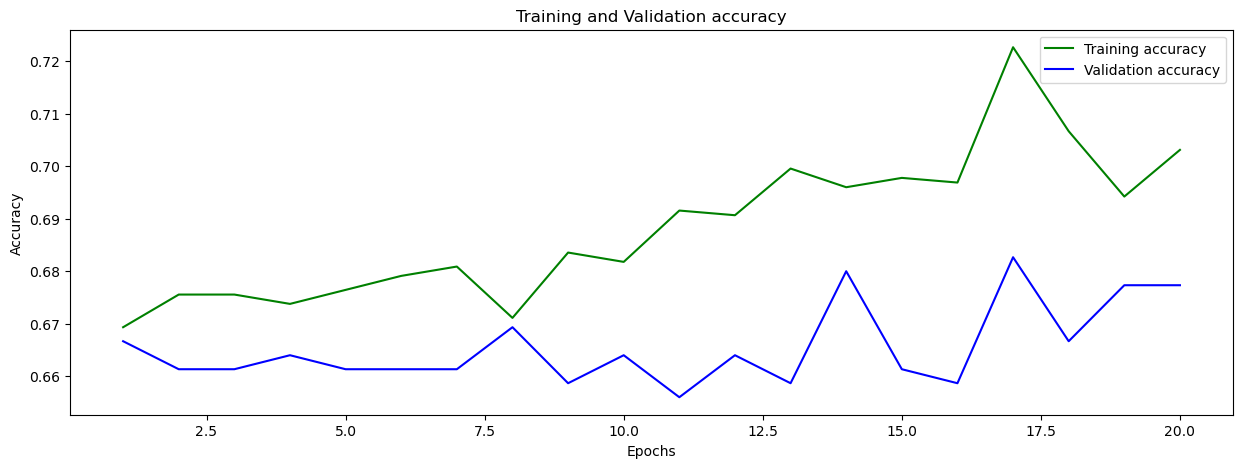

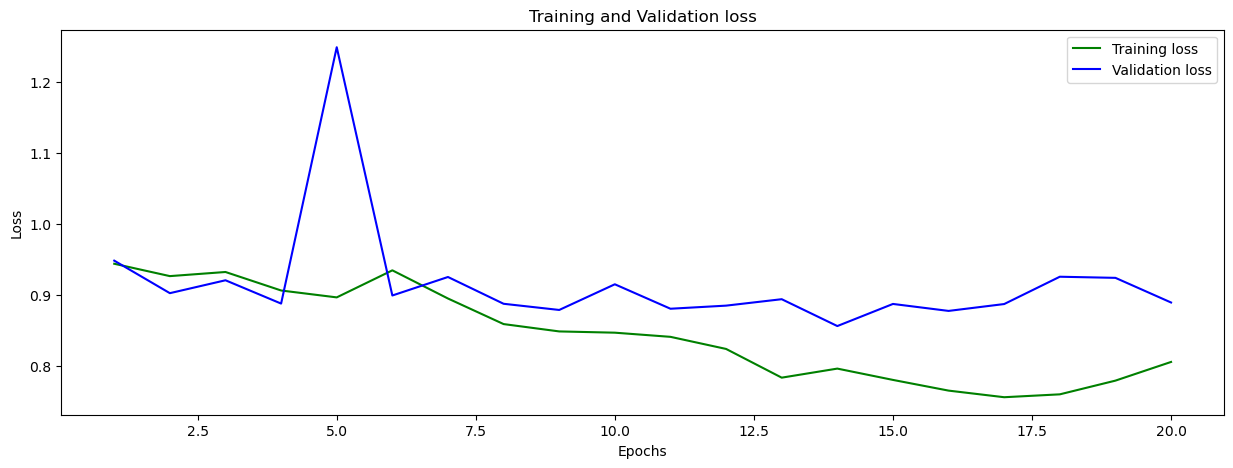

In [35]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
